In [2]:
import math
import h5py
import numpy as np 
import netCDF4 as nc
from netCDF4 import Dataset
from sklearn.linear_model import LinearRegression
import xarray as xr
import matplotlib.pyplot as plt
import time
import pandas as pd
import datetime
import random

import os
import torch
print(torch.__version__)
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torch import from_numpy
from torch import manual_seed as torch_manual_seed
from torch.cuda import max_memory_allocated, set_device, manual_seed_all
from torch.backends import cudnn

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from functools import partial

2.2.0+cu118


# PRECT Data

### Load and Convert to Dataframe

In [23]:
ds = xr.open_dataset("prect_data.nc", decode_times=False)
df = ds.to_dataframe()
df.head()

PRECT
simulation year region            
1001.001   1940 Central  12.205217
                North    15.767306
                South     7.383293
           1941 Central  17.994605
                North    35.415431

In [24]:
#condition = df.index.get_level_values('simulation') == "1001.001"
#subset_df = df.loc[condition]
#subset_df.head(10)

In [25]:
regions = np.array(df.index.get_level_values("region").unique())
years = np.array(df.index.get_level_values("year").unique())
simulations = np.array(df.index.get_level_values("simulation").unique())
#simulations, regions, years

### Detrend PRECT Data

In [26]:
from scipy.signal import detrend

df_notrend = df.copy()

for sim in simulations:
    condition = df.index.get_level_values('simulation') == sim
    subset_df = df.loc[condition]
    for reg in regions:
        condition2 = subset_df.index.get_level_values('region') == reg
        subset_df2 = subset_df.loc[condition2]
        x = years.reshape(-1,1).astype(int)
        y = subset_df2.PRECT.values
        dt = detrend(y)
        condition3 = df.index.get_level_values('region') == reg
        df_notrend.loc[condition & condition3, 'PRECT'] = dt

df_notrend
PRECT = df_notrend.copy()




### Reorder PRECT Simulations to Follow SST / Nino order

In [39]:
# These values are the order of simulations of the SST / Nino Data

values = ['1001.001', '1021.002', '1041.003', '1061.004', '1081.005', '1101.006', '1121.007', '1141.008', '1161.009', '1181.010',
          '1231.001', '1231.002', '1231.003', '1231.004', '1231.005', '1231.006', '1231.007', '1231.008', '1231.009', '1231.010',
          '1251.001', '1251.002', '1251.003', '1251.004', '1251.005', '1251.006', '1251.007', '1251.008', '1251.009', '1251.010',
          '1281.001', '1281.002', '1281.003', '1281.004', '1281.005', '1281.006', '1281.007', '1281.008', '1281.009', '1281.010',
          '1301.001', '1301.002', '1301.003', '1301.004', '1301.005', '1301.006', '1301.007', '1301.008', '1301.009', '1301.010',
          '1011.001', '1031.002', '1051.003', '1071.004', '1091.005', '1111.006', '1131.007', '1151.008', '1171.009', '1191.010',
          '1231.011', '1231.012', '1231.013', '1231.014', '1231.015', '1231.016', '1231.017', '1231.018', '1231.019', '1231.020',
          '1251.011', '1251.012', '1251.013', '1251.014', '1251.015', '1251.016', '1251.017', '1251.018', '1251.019', '1251.020',
          '1281.011', '1281.012', '1281.013', '1281.014', '1281.015', '1281.016', '1281.017', '1281.018', '1281.019', '1281.020',
          '1301.011', '1301.012', '1301.013', '1301.014', '1301.015', '1301.016', '1301.017', '1301.018', '1301.019', '1301.020']

# Years
years = list(range(1940, 2014))

# Regions
regions = ['Central', 'North', 'South']

# Generate tuples
result = []

for value in values:
    for year in years:
        for region in regions:
            result.append((str(value), str(year), region))

# Printing first few tuples to verify
print(result[:10])


[('1001.001', '1940', 'Central'), ('1001.001', '1940', 'North'), ('1001.001', '1940', 'South'), ('1001.001', '1941', 'Central'), ('1001.001', '1941', 'North'), ('1001.001', '1941', 'South'), ('1001.001', '1942', 'Central'), ('1001.001', '1942', 'North'), ('1001.001', '1942', 'South'), ('1001.001', '1943', 'Central')]


In [45]:
PRECT_right_order = PRECT.reindex(result)

PRECT_right_order.head(15)

PRECT
simulation year region            
1001.001   1940 Central   1.696816
                North    -4.384861
                South     2.359652
           1941 Central   7.414276
                North    15.164542
                South    -0.276591
           1942 Central   1.005114
                North    -0.246500
                South     1.693045
           1943 Central  -5.456921
                North    -6.427475
                South    -2.480597
           1944 Central   7.008837
                North    11.163982
                South     1.050004

In [42]:
#PRECT.to_csv("Detrended_PRECT.csv")

PRECT_right_order.to_csv("Detrended_PRECT_reordered.csv")

In [53]:
df_notrend.describe()

,PRECT
count,2.220000e+04
mean,-3.365476e-16
std,4.990587e+00
min,-1.798691e+01
25%,-3.002054e+00
50%,-5.636340e-01
75%,2.616172e+00
max,3.402317e+01


### Sanity Plots to Check PRECT Detrending

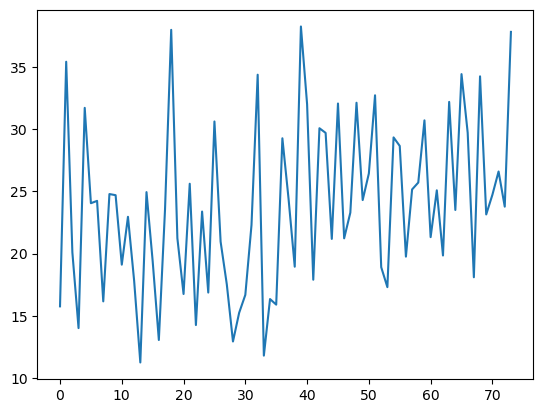

In [54]:
condition1 = df.index.get_level_values('simulation') == "1001.001"
condition2 = df.index.get_level_values('region') == "North"
sub = df.loc[condition1 & condition2]
plt.plot(sub.PRECT.values)

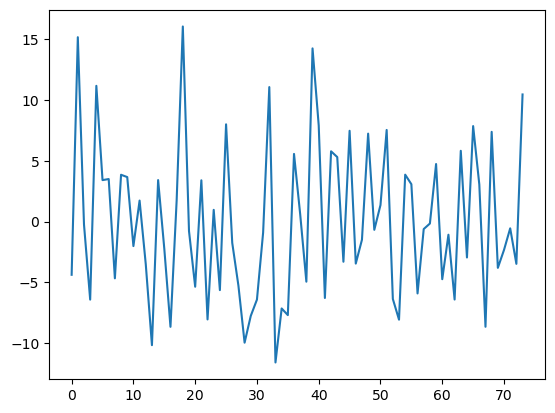

In [55]:
condition1 = df_notrend.index.get_level_values('simulation') == "1001.001"
condition2 = df_notrend.index.get_level_values('region') == "North"
sub = df_notrend.loc[condition1 & condition2]
plt.plot(sub.PRECT.values)

In [56]:
np.mean(df_notrend.reset_index(inplace = False).groupby('simulation')['PRECT'].mean())

-3.318866702983059e-16

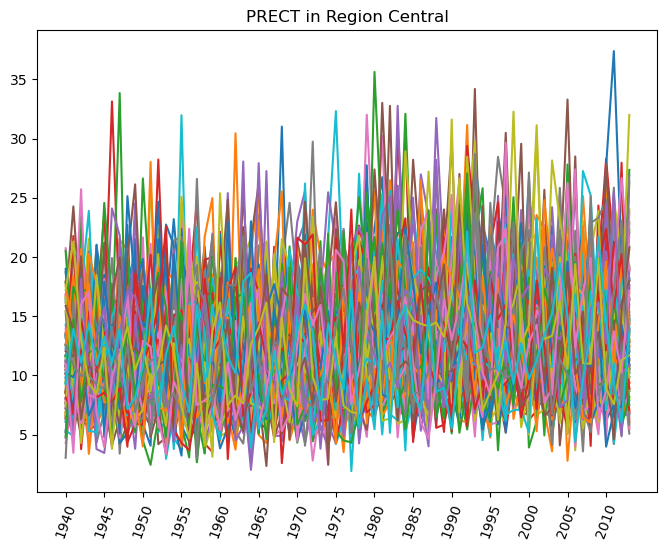

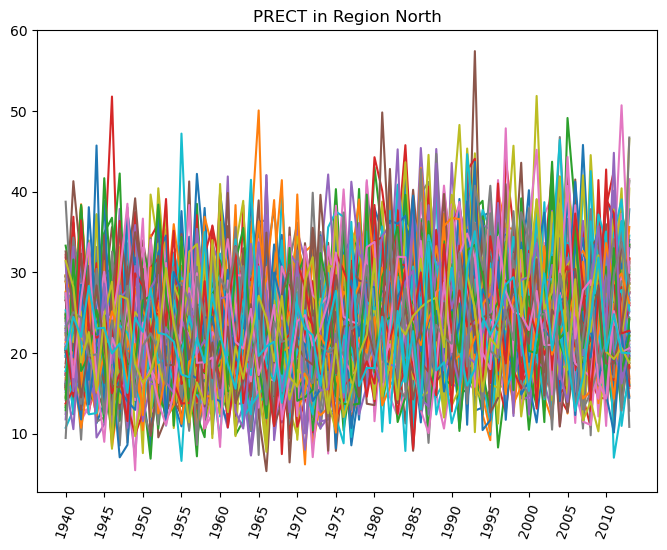

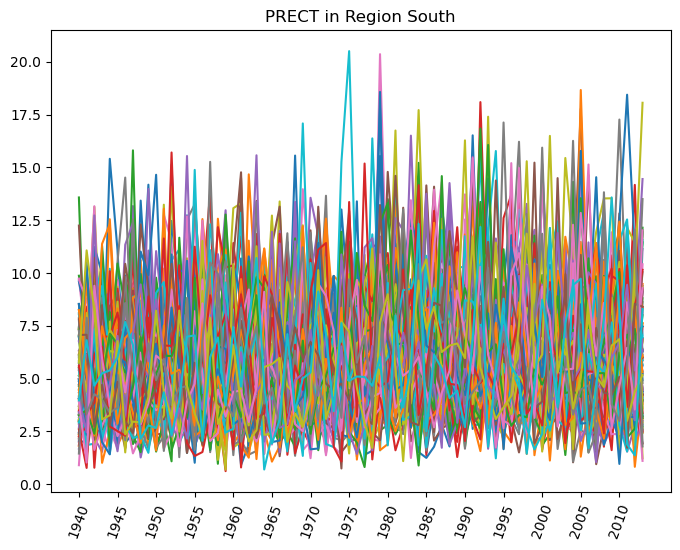

In [57]:
for region in regions:
    condition2 = df.index.get_level_values('region') == region
    fig, ax = plt.subplots(figsize=(8, 6))

    df_filtered = df.loc[condition2].reset_index(inplace=False)

    for simulation in df_filtered['simulation'].unique():
        simulation_data = df_filtered[df_filtered['simulation'] == simulation]
        ax.plot(simulation_data['year'], simulation_data['PRECT'], label=f'Simulation {simulation}')

    ax.legend().remove()
    plt.xticks(rotation=70)
    plt.title(f'PRECT in Region {region}')
    ax.set_xticks(ax.get_xticks()[::5])
plt.show()


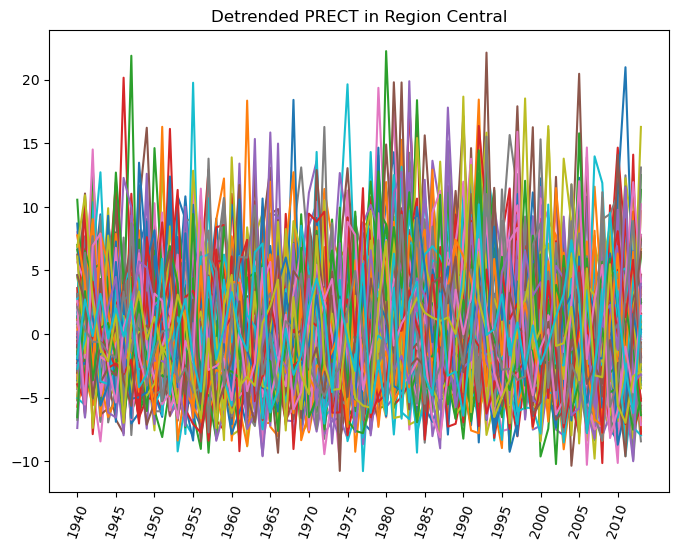

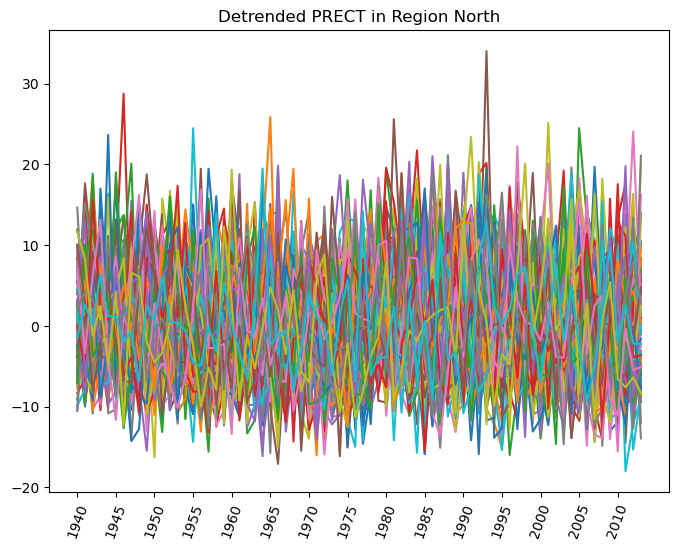

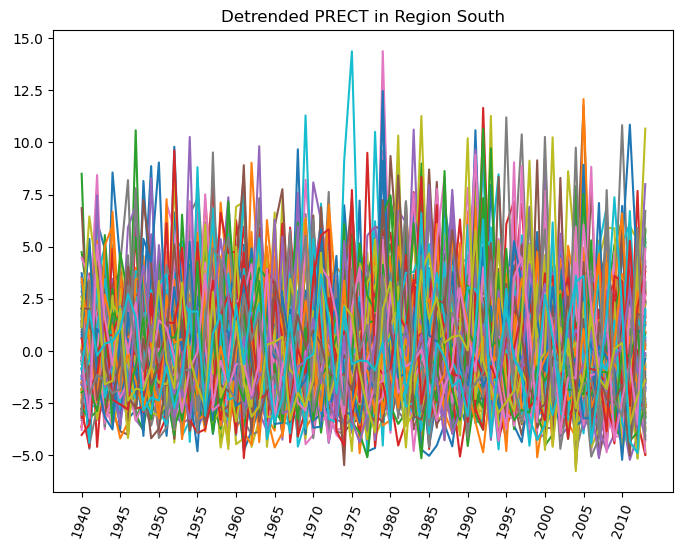

In [58]:
for region in regions:
    condition2 = df_notrend.index.get_level_values('region') == region
    fig, ax = plt.subplots(figsize=(8, 6))

    df_filtered = df_notrend.loc[condition2].reset_index(inplace=False)

    for simulation in df_filtered['simulation'].unique():
        simulation_data = df_filtered[df_filtered['simulation'] == simulation]
        ax.plot(simulation_data['year'], simulation_data['PRECT'], label=f'Simulation {simulation}')

    ax.legend().remove()
    plt.xticks(rotation=70)
    plt.title(f'Detrended PRECT in Region {region}')
    ax.set_xticks(ax.get_xticks()[::5])
plt.show()


# Nino 3.4 Data

### Load Data into Dataframe

In [14]:
#nino = pd.read_csv("test_nino.csv")
nino = pd.read_csv("Nino_Data.csv")
nino.head()

,year,Average_SST,Sim
0,1940,300.755161,1001.001
1,1941,300.476758,1001.001
2,1942,302.393693,1001.001
3,1943,298.560676,1001.001
4,1944,300.111834,1001.001


In [15]:
nino.Sim.unique()

array([1001.001, 1021.002, 1041.003, 1061.004, 1081.005, 1101.006,
       1121.007, 1141.008, 1161.009, 1181.01 , 1231.001, 1231.002,
       1231.003, 1231.004, 1231.005, 1231.006, 1231.007, 1231.008,
       1231.009, 1231.01 , 1251.001, 1251.002, 1251.003, 1251.004,
       1251.005, 1251.006, 1251.007, 1251.008, 1251.009, 1251.01 ,
       1281.001, 1281.002, 1281.003, 1281.004, 1281.005, 1281.006,
       1281.007, 1281.008, 1281.009, 1281.01 , 1301.001, 1301.002,
       1301.003, 1301.004, 1301.005, 1301.006, 1301.007, 1301.008,
       1301.009, 1301.01 , 1011.001, 1031.002, 1051.003, 1071.004,
       1091.005, 1111.006, 1131.007, 1151.008, 1171.009, 1191.01 ,
       1231.011, 1231.012, 1231.013, 1231.014, 1231.015, 1231.016,
       1231.017, 1231.018, 1231.019, 1231.02 , 1251.011, 1251.012,
       1251.013, 1251.014, 1251.015, 1251.016, 1251.017, 1251.018,
       1251.019, 1251.02 , 1281.011, 1281.012, 1281.013, 1281.014,
       1281.015, 1281.016, 1281.017, 1281.018, 1281.019, 1281.

In [12]:
nino = nino.groupby(['Sim', 'year']).sum()
nino

Average_SST
Sim      year             
1001.001 1940   300.755161
         1941   300.476758
         1942   302.393693
         1943   298.560676
         1944   300.111834
...                    ...
1301.020 2009   300.870808
         2010   301.778526
         2011   298.295271
         2012   299.273569
         2013   300.534646

[7400 rows x 1 columns]

In [13]:
nino.reset_index()['Sim'].unique()

array([1001.001, 1011.001, 1021.002, 1031.002, 1041.003, 1051.003,
       1061.004, 1071.004, 1081.005, 1091.005, 1101.006, 1111.006,
       1121.007, 1131.007, 1141.008, 1151.008, 1161.009, 1171.009,
       1181.01 , 1191.01 , 1231.001, 1231.002, 1231.003, 1231.004,
       1231.005, 1231.006, 1231.007, 1231.008, 1231.009, 1231.01 ,
       1231.011, 1231.012, 1231.013, 1231.014, 1231.015, 1231.016,
       1231.017, 1231.018, 1231.019, 1231.02 , 1251.001, 1251.002,
       1251.003, 1251.004, 1251.005, 1251.006, 1251.007, 1251.008,
       1251.009, 1251.01 , 1251.011, 1251.012, 1251.013, 1251.014,
       1251.015, 1251.016, 1251.017, 1251.018, 1251.019, 1251.02 ,
       1281.001, 1281.002, 1281.003, 1281.004, 1281.005, 1281.006,
       1281.007, 1281.008, 1281.009, 1281.01 , 1281.011, 1281.012,
       1281.013, 1281.014, 1281.015, 1281.016, 1281.017, 1281.018,
       1281.019, 1281.02 , 1301.001, 1301.002, 1301.003, 1301.004,
       1301.005, 1301.006, 1301.007, 1301.008, 1301.009, 1301.

### Detrend Nino 3.4 Data

In [61]:
nino_notrend = nino.copy()

for sim in np.array(nino.index.get_level_values("Sim").unique()):
    condition = nino.index.get_level_values('Sim') == sim
    subset_nino = nino.loc[condition]
    y = subset_nino.Average_SST.values
    dt = detrend(y)
    nino_notrend.loc[condition, 'Average_SST'] = dt

nino_notrend.head()

Average_SST
Sim      year             
1001.001 1940     0.327026
         1941     0.051076
         1942     1.970464
         1943    -1.860101
         1944    -0.306490

### Sanity Plots to Check Nino 3.4 Detrending

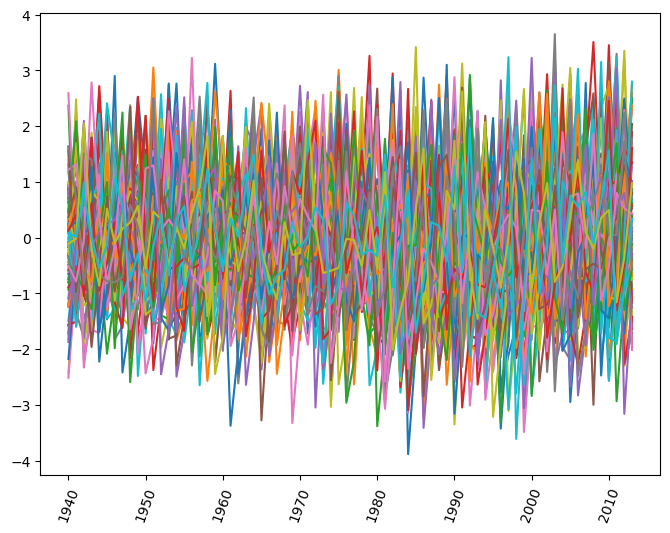

In [62]:
fig, ax = plt.subplots(figsize=(8, 6))

nino_filtered = nino_notrend.reset_index(inplace=False)

for simulation in nino_filtered['Sim'].unique():
    simulation_data = nino_filtered[nino_filtered['Sim'] == simulation]
    ax.plot(simulation_data['year'], simulation_data['Average_SST'], label=f'Simulation {simulation}')

ax.legend().remove()
plt.xticks(rotation=70)
plt.show()


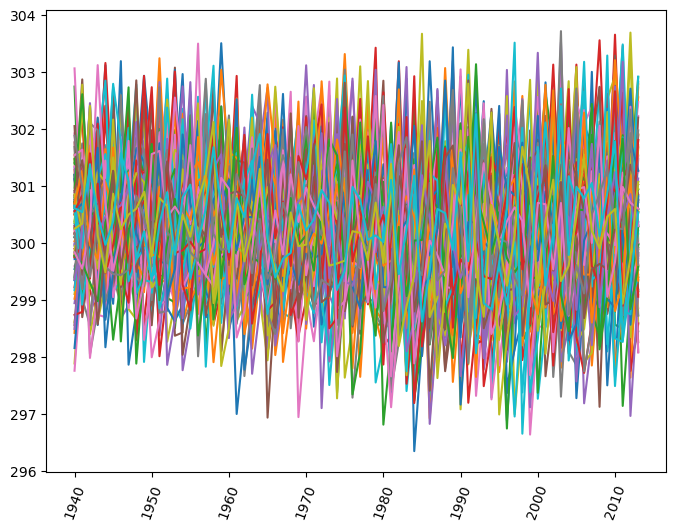

In [63]:
fig, ax = plt.subplots(figsize=(8, 6))

nino_filtered = nino.reset_index(inplace=False)

for simulation in nino_filtered['Sim'].unique():
    simulation_data = nino_filtered[nino_filtered['Sim'] == simulation]
    ax.plot(simulation_data['year'], simulation_data['Average_SST'], label=f'Simulation {simulation}')

ax.legend().remove()
plt.xticks(rotation=70)
plt.show()


# SST Data

### Load Raw SST Data as Xarray Dataset

In [72]:
ds = xr.open_dataset("SST_Data.nc", decode_times=False)


In [73]:
ds

<xarray.Dataset>
Dimensions:  (lat: 192, lon: 288, time: 7400)
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * time     (time) int64 0 366 731 1096 1461 ... 25203 25568 25933 26298 26664
Data variables:
    SST      (time, lat, lon) float32 ...

### Detrend SST Data

In [74]:
#ds2 = ds.copy(deep=True) 
#for _ in range(len(ds['lat'].values)):
#     for i in range(len(ds['lon'].values)):
#         #print(_, i)
#         lat_lon_array = ds['SST'][:, _, i].values
#         if np.mean(lat_lon_array) == 0:
#             continue
#         for sim in range(0, 7399, 74):
#             detrended = detrend(lat_lon_array[sim:sim + 74])
#             ds2['SST'][sim:sim + 74, _, i] = detrended




# The above code will detrend the SST data, but now that it is done, just load the file
ds2 = xr.open_dataset("Detrended_SST.nc", decode_times=False)


### Sanity Plots to Check SST Detrending

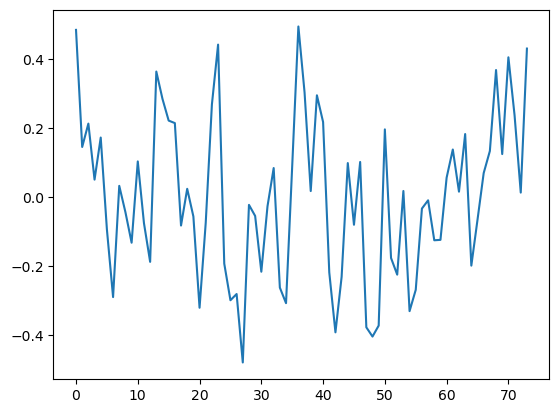

In [75]:
plt.plot(ds2['SST'][0:74, 45, 34].values)

In [76]:
ds2==ds

<xarray.Dataset>
Dimensions:  (lat: 192, lon: 288, time: 7400)
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * time     (time) int64 0 366 731 1096 1461 ... 25203 25568 25933 26298 26664
Data variables:
    SST      (time, lat, lon) bool True True True True ... False False False

In [77]:
np.mean(ds['SST'][74:148, 122, 100].values)

302.5872

In [78]:
np.mean(ds2['SST'][74:148, 122, 100].values)

5.649876e-05

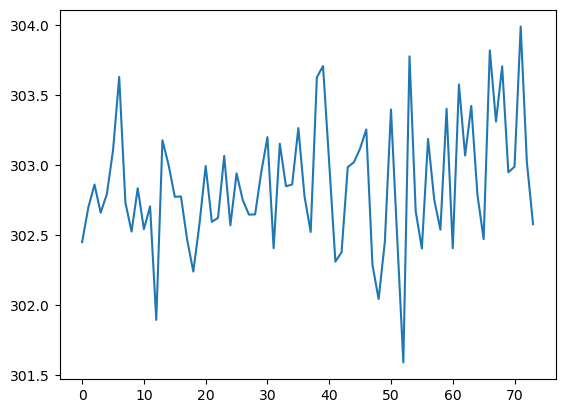

In [79]:
plt.plot(ds['SST'][74:148, 120, 100].values)

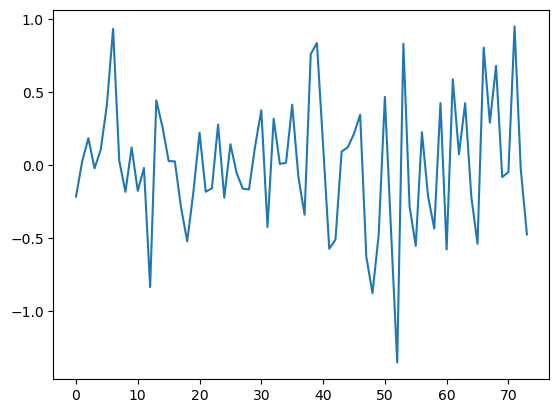

In [80]:
plt.plot(ds2['SST'][74:148, 120, 100].values)

In [81]:
sst[0,:,:]

<xarray.DataArray 'SST' (lat: 192, lon: 288)>
[55296 values with dtype=float32]
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
    time     int64 0
Attributes:
    units:         K
    long_name:     sea surface temperature
    cell_methods:  time: mean

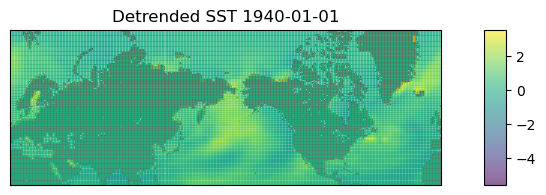

In [82]:
from mpl_toolkits.basemap import Basemap

lats = ds2['lat'][:]
lons = ds2['lon'][:]
sst = ds2['SST'][:]

lon, lat = np.meshgrid(lons, lats)


map = Basemap(projection='merc', resolution = 'i',llcrnrlon=0.,llcrnrlat=10.,urcrnrlon=360.,urcrnrlat=80.)
x, y = map(lon, lat)
map.drawcoastlines
#map.drawstates
map.drawcountries
map.drawlsmask(land_color='brown', ocean_color='#CCFFFF') # can use HTML names or codes for colors
map.drawcounties() # you can even add counties (and other shapefiles!)

color_scheme = map.pcolor(x, y, np.squeeze(sst[0,:,:]), alpha = 0.6)
#color_scheme = map.contourf(x, y, sst[100,:,:])
color_bar = map.colorbar(color_scheme, location = 'right', pad = '10%')

plt.title('Detrended SST 1940')
plt.show()

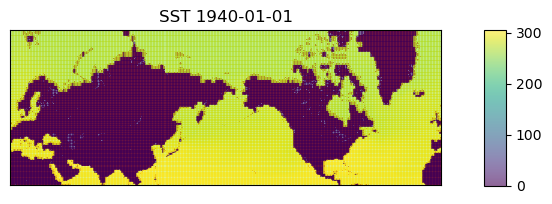

In [83]:
lats = ds['lat'][:]
lons = ds['lon'][:]
sst = ds['SST'][:]

lon, lat = np.meshgrid(lons, lats)


map = Basemap(projection='merc', resolution = 'i',llcrnrlon=0.,llcrnrlat=10.,urcrnrlon=360.,urcrnrlat=80.)
x, y = map(lon, lat)
map.drawcoastlines
#map.drawstates
map.drawcountries
map.drawlsmask(land_color='brown', ocean_color='#CCFFFF') # can use HTML names or codes for colors
map.drawcounties() # you can even add counties (and other shapefiles!)

color_scheme = map.pcolor(x, y, np.squeeze(sst[0,:,:]), alpha = 0.6)
#color_scheme = map.contourf(x, y, sst[100,:,:])
color_bar = map.colorbar(color_scheme, location = 'right', pad = '10%')

plt.title('SST 1940-01-01')
plt.show()

In [84]:
#ds2.to_netcdf('Detrended_SST.nc')